In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
os.getcwd()

'/kaggle/working'

In [3]:
df_train = pd.read_csv("../input/prostate-cancer-grade-assessment/train.csv")
df_train.head(10)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0
5,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0
6,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3
7,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1,3+3
8,003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3
9,003d4dd6bd61221ebc0bfb9350db333f,karolinska,1,3+3


In [4]:
train_img_path = "/kaggle/input/prostate-cancer-grade-assessment/train_images"
label_path = "/kaggle/input/prostate-cancer-grade-assessment/train_label_masks"

train_img = [img for img in os.listdir(train_img_path)]
train_label = [label for label in os.listdir(label_path)]

train_img = list(sorted(train_img))
train_label = list(sorted(train_label))

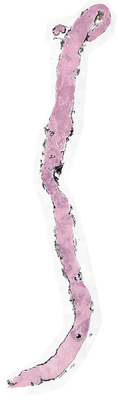

PROVIDED BY: radboud
ISUP Grade: 5, Gleason Grade: 4+5


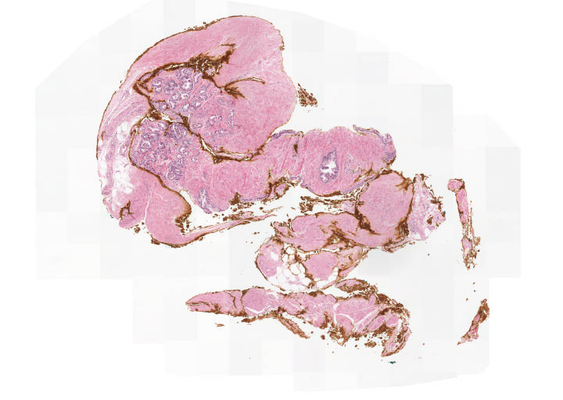

PROVIDED BY: radboud
ISUP Grade: 1, Gleason Grade: 3+3


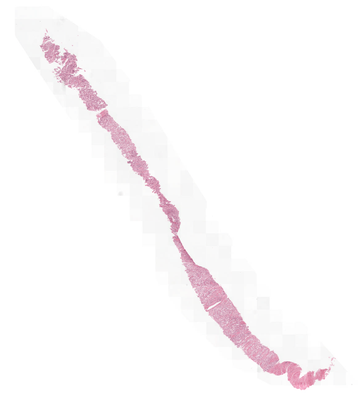

PROVIDED BY: radboud
ISUP Grade: 4, Gleason Grade: 4+4


In [5]:
from matplotlib import rcParams
import openslide
import cv2
from IPython.display import display

# rcParams["figure.figsize"] = 15, 15

for i in range(22, 25):
    img = openslide.OpenSlide(train_img_path + "/" + train_img[i])
    display(img.get_thumbnail(size=(600, 400)))
    img.close()
    d = df_train.loc[df_train["image_id"] == train_img[i][:-5]]
    print(f"PROVIDED BY: {d.data_provider.values[0]}")
    print(f"ISUP Grade: {d.isup_grade.values[0]}, Gleason Grade: {d.gleason_score.values[0]}")

**RADBOUDUMC:**
* 0: background (non tissue) or unknown
* 1: stroma (connective tissue, non-epithelium tissue)
* 2: healthy (benign) epithelium
* 3: cancerous epithelium (Gleason 3)
* 4: cancerous epithelium (Gleason 4)
* 5: cancerous epithelium (Gleason 5)

**KAROLINSKA:**
* 0: background (non tissue) or unknown
* 1: benign tissue (stroma and epithelium combined)
* 2: cancerous tissue (stroma and epithelium combined)

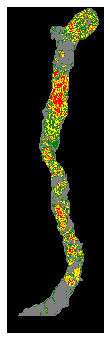

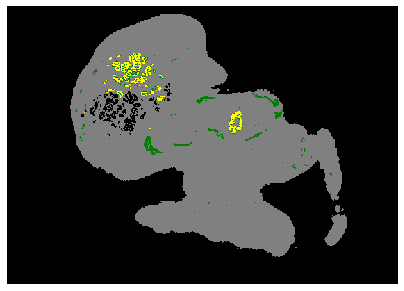

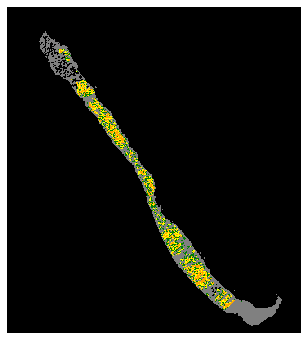

In [6]:
import matplotlib

rcParams["figure.figsize"] = 7, 6

for i in range(22, 25):
    mask = openslide.OpenSlide(label_path + "/" + train_label[i])
    mask = mask.get_thumbnail(size=(600, 400))
    mask = np.asarray(mask)
    mask = mask[:,:,0]
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

    plt.imshow(mask, cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
    plt.axis('off')
    plt.show()
#     mask.close()

## IMAGE PREPROCESSING

In [7]:
import cv2

SIZE = 200

resized_imgs_path = "../input/panda-resized-train-data-512x512/train_images/train_images"
img_array = []
for i in os.listdir(resized_imgs_path):
    img = resized_imgs_path + "/" + i
    img = cv2.resize(cv2.imread(img), (SIZE, SIZE))
    img_array.append(img)

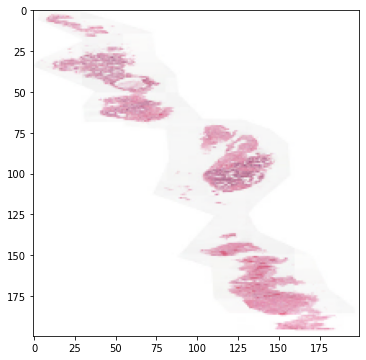

In [8]:
plt.imshow(img_array[1])
plt.show()

In [9]:
from sklearn.preprocessing import LabelBinarizer

train_y = list(df_train['isup_grade'].values)
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)

In [10]:
train_y_multi = np.empty(train_y.shape, dtype=train_y.dtype)
train_y_multi[:, 5] = train_y[:, 5]

for i in range(4, -1, -1):
    train_y_multi[:, i] = np.logical_or(train_y[:, i], train_y_multi[:,i+1])

In [11]:
train_y_multi.sum(axis=0)

array([10616,  7724,  5058,  3715,  2473,  1224])

In [12]:
train_x = np.reshape(img_array, (len(img_array), SIZE, SIZE, 3))

In [13]:
df_test = pd.read_csv("../input/prostate-cancer-grade-assessment/test.csv")
df_test.head(10)

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


In [14]:
test_img = [img+".tiff" for img in df_test['image_id'].values]

In [15]:
test_img_path = '../input/prostate-cancer-grade-assessment/test_images'
test_x = []

if os.path.exists(test_img_path):
    for i in range(len(test_img)):
        img = test_img_path + "/" + test_img[i]
        img = preprocessing_img(img)
        test_x.append(img)
    test_x = np.reshape(train_img, (len(test_img), SIZE, SIZE, 3))
else:
    test_x = np.random.rand(len(test_img),SIZE, SIZE, 3)

In [16]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y_multi, train_size=0.8, random_state=42)

In [17]:
from keras.applications import DenseNet121

densenet = DenseNet121(
    weights = '../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(SIZE, SIZE, 3)
)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as ly
from tensorflow.keras.optimizers import Adam

model = Sequential([
    densenet,
    ly.GlobalAveragePooling2D(),
    ly.Dropout(0.8),
    ly.Dense(6, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.01), metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 6, 6, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6150      
Total params: 7,043,654
Trainable params: 6,960,006
Non-trainable params: 83,648
_________________________________________________________________


In [20]:
from keras.preprocessing.image import ImageDataGenerator

data = ImageDataGenerator(
    zoom_range = 0.15,
    fill_mode="nearest",
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True
)

data = data.flow(train_x, train_y, batch_size=10, seed=42)

In [21]:
history = model.fit_generator(
    data, steps_per_epoch=train_x.shape[0] / 10,
    epochs=10,
    validation_data=(val_x, val_y)
)

Epoch 1/10
850/849 [==============================] - 106s 125ms/step - loss: 0.6939 - accuracy: 0.9987 - val_loss: 1.5805 - val_accuracy: 1.0000
Epoch 2/10
850/849 [==============================] - 96s 113ms/step - loss: 0.5170 - accuracy: 1.0000 - val_loss: 0.4856 - val_accuracy: 1.0000
Epoch 3/10
850/849 [==============================] - 97s 114ms/step - loss: 0.4879 - accuracy: 1.0000 - val_loss: 1.2416 - val_accuracy: 1.0000
Epoch 4/10
850/849 [==============================] - 97s 114ms/step - loss: 0.4730 - accuracy: 1.0000 - val_loss: 1.0061 - val_accuracy: 1.0000
Epoch 5/10
850/849 [==============================] - 96s 113ms/step - loss: 0.4781 - accuracy: 1.0000 - val_loss: 0.4894 - val_accuracy: 1.0000
Epoch 6/10
850/849 [==============================] - 99s 116ms/step - loss: 0.4708 - accuracy: 1.0000 - val_loss: 0.4830 - val_accuracy: 1.0000
Epoch 7/10
850/849 [==============================] - 99s 116ms/step - loss: 0.4694 - accuracy: 1.0000 - val_loss: 0.4842 - val_a

In [22]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

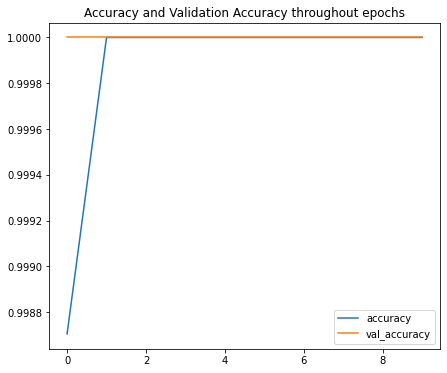

In [23]:
plt.plot(acc)
plt.plot(val_acc)
plt.legend(["accuracy", "val_accuracy"])
plt.title("Accuracy and Validation Accuracy throughout epochs")
plt.show()

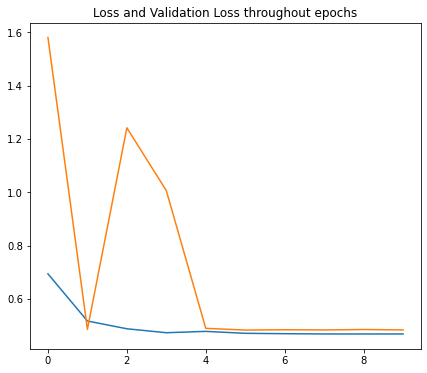

In [24]:
plt.plot(loss)
plt.plot(val_loss)
plt.title("Loss and Validation Loss throughout epochs")
plt.show()

In [25]:
from random import randint

if os.path.exists(test_img_path):
    test_y = model.predict(test_x)
    test_y = test_y > 0.37757874193797547
    test_y = test_y.astype(int).sum(axis=1) - 1
else:
    test_y = [randint(0, 5) for i in range(3)]

df_test['isup_grade'] = test_y
df_test = df_test[["image_id", "isup_grade"]]
df_test.to_csv("submission.csv", index=False)